# Gathering data

In [1]:
import re
import json
import tweepy
import requests
import numpy as np
import pandas as pd
import settings as Settings
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize

In [2]:
tweet_images_response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [3]:
with open('data-files/image_predictions.tsv', 'w') as f:
    f.write(tweet_images_response.content)

In [4]:
auth = tweepy.OAuthHandler(Settings.consumer_key, Settings.consumer_secret)
auth.set_access_token(Settings.access_token, Settings.access_token_secret)

api = tweepy.API(auth)

In [5]:
def get_status(tweet_id):
    try:
        return api.get_status(id=tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)._json
    except:
        # Print the tweet id for manual inspection
        print(tweet_id)
        return 

In [6]:
# status_json = [get_status(tweet_id) for tweet_id in tweets_df['tweet_id']]
# print(status_json)
# with open('data-files/tweet_json.txt', 'w') as f:
#     f.write('\n'.join([json.dumps(s) for s in status_json]))

# Assessing data

In [3]:
# Load flat files into pandas dataframes
tweets_df = pd.read_csv('data-files/twitter-archive-enhanced.csv')
tweet_images_df = pd.read_csv('data-files/image_predictions.tsv', sep='\t')

with open('data-files/tweet_json.txt', 'r') as f:
    tweets_json = [i for i in f.readlines() if not i.startswith('null')]
tweets_info_df = pd.DataFrame.from_records(map(json.loads, tweets_json))
tweets_info_df.head(n=1)

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"{u'symbols': [], u'user_mentions': [], u'hasht...",{u'media': [{u'expanded_url': u'https://twitte...,38938,False,None,892420643555336193,892420643555336193,...,NaN,NaN,NaN,8628,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,False,"{u'follow_request_sent': False, u'has_extended..."


In [4]:
# Investigate the datafields of each tweet json response
tweets_info_df.columns

Index([u'contributors', u'coordinates', u'created_at', u'entities',
       u'extended_entities', u'favorite_count', u'favorited', u'geo', u'id',
       u'id_str', u'in_reply_to_screen_name', u'in_reply_to_status_id',
       u'in_reply_to_status_id_str', u'in_reply_to_user_id',
       u'in_reply_to_user_id_str', u'is_quote_status', u'lang', u'place',
       u'possibly_sensitive', u'possibly_sensitive_appealable',
       u'quoted_status', u'quoted_status_id', u'quoted_status_id_str',
       u'retweet_count', u'retweeted', u'retweeted_status', u'source', u'text',
       u'truncated', u'user'],
      dtype='object')

In [5]:
# Investigate the provided information in the tweet's csv
tweets_df.head(n=1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [6]:
# Check datatypes - column names - null values in the tweets_df 
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
# Check the values of one of the dog_species column [floofer]
tweets_df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [12]:
# Check for duplicated tweets
tweets_df[tweets_df.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [13]:
# Investigate how the [doggo-floofer-pupper-puppo] fields are used
# All these fields are sometimes set to None
tweets_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
228,848213670039564288,8.482121e+17,4.196984e+09,2017-04-01 16:41:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Jerry just apuppologized to me. He said there ...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
974,750056684286914561,NaN,NaN,2016-07-04 20:00:23 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Jameson. He had a few too many in the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750056684...,11,10,Jameson,None,None,None,None
2041,671542985629241344,NaN,NaN,2015-12-01 04:14:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is JD (stands for ""just dog""). He's like ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/671542985...,10,10,JD,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
1556,688828561667567616,NaN,NaN,2016-01-17 21:01:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Brad. His car probably has a spoi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688828561...,9,10,Brad,None,None,None,None


In [7]:
# Check the range of rating-{numerator, denominator} columns
tweets_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [9]:
# Check if the tweet has an invalid rating
# Definition of invalid rating:
# 1) tweet has multiple NUM/NUM fields.
# 2) denominator isn't a multiple of 10.
# 3) numerator or denominator equals 0.

def tweet_has_invalid_rating(t):
    tweet_text = t['text']
    l = re.findall(r'([\d]{1,}[\.[\d]{0,}]?/[\d]{1,})', tweet_text)
    if len(l) == 1:
        num, den = l[-1].split('/')
        if float(num) == 0.0 or float(den) == 0.0:
            return t.name
        if float(num) != float(t['rating_numerator']) or float(den) != float(t['rating_denominator']):
            return t.name
        return None
    return t.name

In [10]:
# Export tweets with invalid ratings to raw-invalid-ratings.csv
col = tweets_df.apply(tweet_has_invalid_rating, axis=1)
indexes = col.dropna()
invalid_ratings_df = tweets_df.loc[indexes][['text', 'rating_numerator', 'rating_denominator', 'tweet_id']]
invalid_ratings_df.to_csv('data-files/raw-invalid-ratings.csv')

In [17]:
# Check how the dog_species fields are filled
cols = ['doggo', 'floofer', 'pupper', 'puppo']
mask = pd.Series(tweets_df.shape[0] * [0], dtype=int)
for col in cols:
    mask += (tweets_df[col] == col).astype(int)
print(mask.value_counts())
# Show a sample for the tweets that has 2 different dog_species
tweets_df[mask==2].sample(n=3)

0    1976
1     366
2      14
dtype: int64


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,doggo,None,pupper,None
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo,None,pupper,None


In [11]:
# Check the invalid dog names (names with small initial)
small_initial_names = tweets_df[tweets_df['name'].apply(lambda name: name[0].islower())]['name'].unique()
small_initial_names

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [19]:
# Make sure that light isn't the dog's name
tweets_df[tweets_df['name']=='light']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2001,672482722825261057,NaN,NaN,2015-12-03 18:29:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is light saber pup. Ready to fight off ev...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672482722...,10,10,light,None,None,None,None


In [20]:
# Make sure that mad isn't the dog's name
tweets_df[tweets_df['name']=='mad']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
682,788552643979468800,NaN,NaN,2016-10-19 01:29:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to mad pupper. You kn...,7.363926e+17,4.196984e+09,2016-05-28 03:04:00 +0000,"https://vine.co/v/iEggaEOiLO3,https://vine.co/...",13,10,mad,None,None,pupper,None
1095,736392552031657984,NaN,NaN,2016-05-28 03:04:00 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Say hello to mad pupper. You know what you did...,NaN,NaN,NaN,https://vine.co/v/iEggaEOiLO3,13,10,mad,None,None,pupper,None


In [21]:
# Find the number of tweets where the dog's name is None
tweets_df[tweets_df['name'] =='None']['name'].shape

(745,)

In [22]:
tweet_images_df.sample()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1829,836001077879255040,https://pbs.twimg.com/media/C5oSiskU0AE8sJ_.jpg,4,Samoyed,0.963558,True,white_wolf,0.019848,False,malamute,0.005904,True


In [23]:
# Investigate the tweets_image dataframe
tweet_images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.0+ KB


In [24]:
# Investigate the tweets_image dataframe
tweet_images_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [25]:
tweet_images_df['tweet_id'].duplicated().sum()

0

### twitter-archive-enhanced.csv:
- Change type of `timestamp` to datetime.
- Rename `timestamp` to `tweet_creation_time`.
- Replace **None** in `['doggo', 'floofer', 'pupper', 'puppo']` with **NaN**.
- Create new dataframe to store the information of the dogs' species instead of `['doggo', 'floofer', 'pupper', 'puppo']`.
- Drop the `['doggo', 'floofer', 'pupper', 'puppo']` columns from the dataframe.
- Update tweets with wrong ratings with the updated correct one from the `corrected-ratings.csv` file.
- Drop tweets with invalid ratings using the `invalud-ratings.csv` file.
- Replace wrong dogs' names with **NaN**.<br>
('such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an', 'very', 'just', 'my', 'his', 'actually', 'getting', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'light', 'space', 'None').

### tweet_json.txt:
- Merge the columns `[id, lang, retweet_count, favorite_count]` into the main dataframe.
- Add prefix `tweet_` to columns' names.


### image_predictions.tsv:
- Rename the names of the classification columns to more meaningful names.

# Data Cleaning

In [12]:
tweets_df_clean = tweets_df.copy()

## Missing data

### Define
* Drop retweeted tweets

### Code

In [14]:
tweets_df_removed_retweets = (
    tweets_df_clean[tweets_df_clean['text'].apply(
        lambda t: not t.startswith('RT'))].copy())

In [15]:
tweets_df_removed_retweets.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Test

In [21]:
assert(tweets_df_removed_retweets.shape[0] == tweets_df_clean.shape[0]-tweets_df_clean['text'].str.startswith('RT').sum())

### Define
- Update ratings of tweets with wrongly extracted ratings.

In [22]:
updated_ratings_df = pd.read_csv('data-files/corrected-ratings.csv', index_col='index')
updated_ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 45 to 2335
Data columns (total 4 columns):
text                  33 non-null object
rating_numerator      33 non-null float64
rating_denominator    33 non-null int64
Unnamed: 4            3 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.3+ KB


In [23]:
tweets_df_fixed_ratings = tweets_df_removed_retweets.copy()
tweets_df_fixed_ratings.head()
tweets_df_fixed_ratings.update(updated_ratings_df)

### Test

In [24]:
# Check if the tweet has an invalid rating
# Definition of invalid rating:
# 1) tweet has multiple NUM/NUM fields.
# 2) denominator isn't a multiple of 10.
# 3) numerator or denominator equals 0.

def tweet_has_invalid_rating(t):
    tweet_text = t['text']
    l = re.findall(r'([\d]{1,}[\.[\d]{0,}]?/[\d]{1,})', tweet_text)
    if l[-1][-1]=='0':
        num, den = l[-1].split('/')
        if float(num) == 0.0 or float(den) == 0.0:
            return True
    return t['rating_numerator'] !=0 and t['rating_denominator'] !=0 and t['rating_denominator']%10 == 0 

In [25]:
assert(tweets_df_fixed_ratings[~tweets_df_fixed_ratings.apply(tweet_has_invalid_rating, axis=1)].shape[0]==3)

### Define
- Drop tweets that have irrelevant ratings [invalid content].

### Code

In [26]:
invalid_tweets_df = pd.read_csv('data-files/invalid-ratings.csv', index_col='index')

In [27]:
tweets_df_valid_ratings = tweets_df_fixed_ratings.copy()
tweets_df_valid_ratings.drop(index=invalid_tweets_df.index, inplace=True)

### Test

In [28]:
assert(tweets_df_valid_ratings.shape[0] + invalid_tweets_df.shape[0] == tweets_df_fixed_ratings.shape[0])

### Define
- Delete the records of tweets that are not available in the tweets_info dataframe [Deleted from twitter records].

### Code

In [29]:
tweets_df_valid_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2168 non-null int64
in_reply_to_status_id         75 non-null float64
in_reply_to_user_id           75 non-null float64
timestamp                     2168 non-null object
source                        2168 non-null object
text                          2168 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2112 non-null object
rating_numerator              2168 non-null float64
rating_denominator            2168 non-null float64
name                          2168 non-null object
doggo                         2168 non-null object
floofer                       2168 non-null object
pupper                        2168 non-null object
puppo                         2168 non-null object
dtypes: float64(6), int64(1), obje

In [30]:
deleted_tweets = [t_in for t_in, t_id in tweets_df_valid_ratings['tweet_id'].iteritems() 
                  if not tweets_info_df['id'].isin([t_id]).sum()]
tweets_df_ava = tweets_df_valid_ratings.copy()
tweets_df_ava.drop(index=deleted_tweets, axis=0, inplace=True)

### Test

In [31]:
assert(len(deleted_tweets)+tweets_df_ava.shape[0] == tweets_df_valid_ratings.shape[0])

### Define
- Replace 'None' values with NaN in columns [doggo, floofer, pupper, puppo].

### Code

In [32]:
tweets_df_fixed_nan = tweets_df_ava.copy()

In [33]:
species_cols = ['doggo', 'floofer', 'pupper', 'puppo']
for col in species_cols:
    tweets_df_fixed_nan.loc[tweets_df_fixed_nan[col] == 'None', col] = np.nan

### Test

In [34]:
for col in species_cols:
    # Count no of null values and value == col
    nrows_proper_values = (
        tweets_df_fixed_nan[col].isnull().sum() +
        tweets_df_fixed_nan[tweets_df_fixed_nan[col]==col].shape[0])
    assert(nrows_proper_values == tweets_df_fixed_nan.shape[0])

## Data tideness

### Define (Create new table for dog species)
- Create dataframe of two columns dog_species, tweet_id from the columns [doggo, floofer, pupper, puppo].

In [35]:
tweets_df_tidy = tweets_df_fixed_nan.copy()
dataframes = []
species_cols = ['doggo', 'floofer', 'pupper', 'puppo']
for col in species_cols:
    dataframes.append(tweets_df_tidy[~ tweets_df_tidy[col].isnull()][['tweet_id', col]])
    dataframes[-1].columns = ['tweet_id', 'dog_species']

In [36]:
for dataframe in dataframes:
    print(dataframe.sample())

               tweet_id dog_species
956  751583847268179968       doggo
               tweet_id dog_species
774  776218204058357768     floofer
                tweet_id dog_species
1321  706310011488698368      pupper
               tweet_id dog_species
439  819952236453363712       puppo


In [37]:
tweets_dog_species_df = pd.concat(dataframes)
tweets_dog_species_df.sample()

,tweet_id,dog_species
1049,743222593470234624,pupper


In [38]:
tweets_df_tidy.drop(columns=species_cols, axis=1, inplace=True)

### Test
- Make sure that the species columns are dropped.
- Make sure that each tweet with non-missing dog species has a record in the new **tweet_dog_species_df**.

In [39]:
for col in species_cols:
    assert(col not in tweets_df_tidy.columns)

In [40]:
mask = pd.Series(tweets_df_fixed_nan.shape[0] * [0], dtype=int)
for col in species_cols:
    mask += (tweets_df_fixed_nan[col] == col).astype(int)
assert(tweets_dog_species_df.shape[0] == 2 * mask.value_counts()[2]+mask.value_counts()[1])

### Define
- Merge the tweet_df and tweet_info dataframes.

### Code

In [41]:
tweets_info_df.rename({'id': 'tweet_id'}, axis='columns', inplace=True)
tweets_df_merged = tweets_df_tidy.merge(
    tweets_info_df[['tweet_id', 'favorite_count', 'lang', 'retweet_count']],
    on='tweet_id')
tweets_df_merged = tweets_df_merged.merge(tweet_images_df, on='tweet_id', how='left')

### Test

In [42]:
assert(tweets_df_merged.shape[0] == tweets_df_tidy.shape[0])

## Quality

### Define
- Fix the type of column timestamp to datetime
- Rename column timestamp to tweet_creation_time

### Code

In [43]:
tweets_df_clean = tweets_df_merged.copy()
tweets_df_clean['tweet_creation_time'] = pd.to_datetime(tweets_df_clean['timestamp'])
tweets_df_clean.drop(columns=['timestamp'], axis=1, inplace=True)

### Test

In [44]:
assert(np.issubdtype(tweets_df_clean['tweet_creation_time'].dtype, np.datetime64))
assert('timestamp' not in tweets_df_clean.columns)
assert('tweet_creation_time' in tweets_df_clean.columns)

### Define
- Dogs names aren't accurate & sometimes contain stopwords.

### Code

In [45]:
dog_names = ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
             'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
             'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
             'officially', 'life', 'light', 'space', 
             'None'
            ]

In [46]:
row_mask = tweets_df_clean['name'].apply(lambda dog_name: dog_name in dog_names)
tweets_df_clean.loc[row_mask, 'name'] = np.nan

### Test

In [47]:
tweets_df_clean['name'].value_counts()

Lucy         11
Charlie      11
Cooper       10
Oliver       10
Penny         9
Tucker        9
Sadie         8
Lola          8
Winston       8
Daisy         7
Toby          7
Bella         6
Bailey        6
Koda          6
Stanley       6
Bo            6
Jax           6
Oscar         6
Leo           5
Dave          5
Bentley       5
Chester       5
Buddy         5
Milo          5
Rusty         5
Scout         5
Louis         5
Gus           4
Duke          4
Winnie        4
             ..
Richie        1
Huxley        1
Chadrick      1
Jonah         1
Bobb          1
Laika         1
Beya          1
Balto         1
Lili          1
Sandra        1
Meera         1
Cermet        1
Koko          1
Sprinkles     1
Stephan       1
Clyde         1
Livvie        1
Brudge        1
Grizzie       1
Dawn          1
Mollie        1
Teddy         1
Snoop         1
Lenox         1
Jeremy        1
Philbert      1
Zooey         1
Todo          1
Kanu          1
Opie          1
Name: name, Length: 930,

### Define
Change datatype of ids to int.

In [62]:
tweets_df_clean[['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
                 'retweeted_status_id', 'retweeted_status_user_id']].astype(float).astype(int, errors='ignore')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id
0,8.924206e+17,NaN,NaN,NaN,NaN
1,8.921774e+17,NaN,NaN,NaN,NaN
2,8.918152e+17,NaN,NaN,NaN,NaN
3,8.916896e+17,NaN,NaN,NaN,NaN
4,8.913276e+17,NaN,NaN,NaN,NaN
5,8.910880e+17,NaN,NaN,NaN,NaN
6,8.909719e+17,NaN,NaN,NaN,NaN
7,8.907292e+17,NaN,NaN,NaN,NaN
8,8.906092e+17,NaN,NaN,NaN,NaN
9,8.902403e+17,NaN,NaN,NaN,NaN


In [63]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2167
Data columns (total 27 columns):
tweet_id                      2168 non-null int64
in_reply_to_status_id         75 non-null float64
in_reply_to_user_id           75 non-null float64
tweet_source                  2168 non-null object
tweet_text                    2168 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2112 non-null object
dog_rating_numerator          2168 non-null float64
dog_rating_denominator        2168 non-null float64
name                          1390 non-null object
tweet_favorite_count          2168 non-null int64
tweet_lang                    2168 non-null object
tweet_retweet_count           2168 non-null int64
jpg_url                       1990 non-null object
img_num_in_tweet              1990 non-null float64
prob_class1_in_image          1990 

### Define
Rename columns.

In [64]:
col_names = {'text': 'tweet_text',
             'source': 'tweet_source',
             'rating_denominator': 'dog_rating_denominator',
             'rating_numerator': 'dog_rating_numerator',
             'favorite_count': 'tweet_favorite_count',
             'retweet_count': 'tweet_retweet_count',
             'img_num': 'img_num_in_tweet',
             'lang': 'tweet_lang',
             'p1': 'prob_class1_in_image',
             'p1_conf': 'conf_class1_in_image',
             'p1_dog': 'class1_is_a_dog',
             'p2': 'prob_class2_in_image',
             'p2_conf': 'conf_class2_in_image',
             'p2_dog': 'class2_is_a_dog',
             'p3': 'prob_class3_in_image',
             'p3_conf': 'conf_class3_in_image',
             'p3_dog': 'class3_is_a_dog'
            }
tweets_df_clean.rename(col_names, axis='columns', inplace=True)

# Data export

In [65]:
tweets_df_clean.to_csv('data-files/twitter_archive_master.csv', index=False)
tweets_dog_species_df.to_csv('data-files/tweet-dog-species.csv', index=False)

# Data analysis
- Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook.
- At least three (3) insights and one (1) visualization must be produced.



In [66]:
tweets_features_df = pd.read_csv('data-files/twitter_archive_master.csv')
tweets_dog_species = pd.read_csv('data-files/tweet-dog-species.csv')

## Investigation

In [67]:
import seaborn as sns
sns.set(color_codes=True)

## Univariate

In [68]:
# Check the distribution of the tweet_lang column 
tweets_features_df['tweet_lang'].value_counts()

en     2153
und       6
nl        3
in        2
es        1
et        1
eu        1
tl        1
Name: tweet_lang, dtype: int64

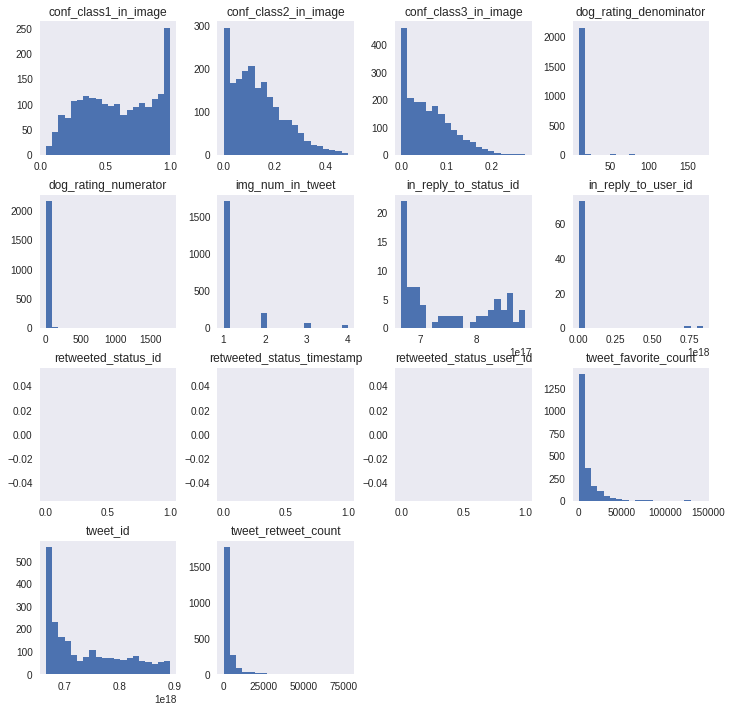

In [69]:
# Explore the distribution of different columns
%matplotlib inline
tweets_features_df.hist(sharex=False, sharey=False, figsize=(12,12), bins=20, grid=False);

In [70]:
tweets_features_df['class1_is_a_dog'].value_counts()

True     1475
False     515
Name: class1_is_a_dog, dtype: int64

In [71]:
# Check the 25%-75% [Interquantile region] values for ratings
rating_per_tweet = tweets_features_df.apply(
    lambda t: t['dog_rating_numerator']/ t['dog_rating_denominator'], axis=1)
rating_per_tweet.quantile(q=[0.25, 0.5, 0.75])

0.25    1.0
0.50    1.1
0.75    1.2
dtype: float64

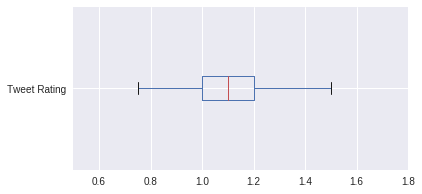

In [72]:
ar = rating_per_tweet[rating_per_tweet<3].to_frame()
ar.columns = ['Tweet Rating']
ax = ar.plot(
    kind='box', figsize=(6, 3), xlim=(0.5,1.8), vert=False);

## Multivariate analysis

In [73]:
t1 = tweets_features_df[tweets_features_df['tweet_favorite_count']==0][
    ['tweet_id', 'tweet_text', 'tweet_retweet_count', 'tweet_favorite_count']]
t2 = tweets_features_df[(tweets_features_df['tweet_text'].str.startswith('RT')) 
                        & (tweets_features_df['tweet_favorite_count']==0)][
    ['tweet_id', 'tweet_text', 'tweet_retweet_count', 'tweet_favorite_count']]
t3 = tweets_features_df[(tweets_features_df['tweet_text'].str.startswith('RT')) 
                        & (tweets_features_df['tweet_favorite_count']!=0)][
    ['tweet_id', 'tweet_text', 'tweet_retweet_count', 'tweet_favorite_count']]
t1.shape, t2.shape, t3.shape
t3.head()

,tweet_id,tweet_text,tweet_retweet_count,tweet_favorite_count


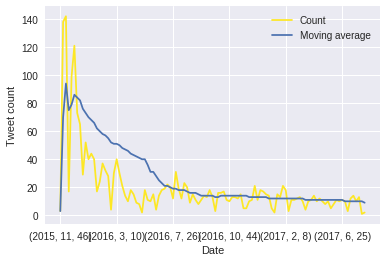

In [74]:
tweets_features_df['tweet_creation_time'] = pd.to_datetime(tweets_features_df['tweet_creation_time'])

count_of_tweets_per_month = tweets_features_df['tweet_creation_time'].groupby(
    [tweets_features_df['tweet_creation_time'].dt.year,
     tweets_features_df['tweet_creation_time'].dt.month,
     tweets_features_df['tweet_creation_time'].dt.week
    ]).count()
ax = count_of_tweets_per_month.plot(kind="line", cmap='viridis_r', label='Count');
N = 30
moving_average = pd.Series([sum(count_of_tweets_per_month[max(0,i-N+1):i+1])/min(i+1, N) for i in range(len(count_of_tweets_per_month))])
moving_average.plot(kind="line", label='Moving average');
ax.set_xlabel('Date');
ax.set_ylabel('Tweet count');
ax.legend();

In [75]:
count_of_tweets_per_month[2015][12][53], count_of_tweets_per_month[2017][6][26]

(29, 10)

In [76]:
tweets_features_df['tweet_favorite_count'].corr(tweets_features_df['tweet_retweet_count'])

0.91652198904952775

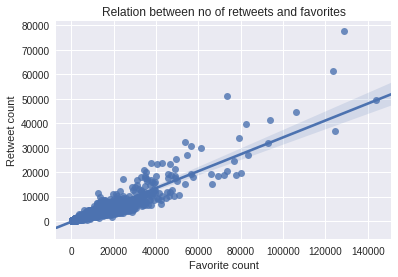

In [77]:
ax = sns.regplot(x="tweet_favorite_count",
                 y="tweet_retweet_count",
                 data=tweets_features_df[tweets_features_df['tweet_favorite_count']!=0],
                 color='b');
ax.set_xlabel('Favorite count');
ax.set_ylabel('Retweet count');
ax.set_title('Relation between no of retweets and favorites');